In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from flask import Flask, render_template
from sklearn.datasets import make_blobs 
from mpl_toolkits.mplot3d import Axes3D
import random
from itertools import groupby
import math
from sklearn.preprocessing import MinMaxScaler



In [3]:
def redimensionner(A,b,precision=2):
    for i in range(len(b)):
        x = b[i][0]/A[i][i]
        if A[i][i] > (10**(precision+1)) and x > 1/10**precision :# Very important precision+1 to avoid stagnation 
            div = math.ceil(x * 10**precision) / 10**precision
            
            b[i][0] = div*10**precision
            A[i][i] = 10**precision
    return A ,b


class linucb_disjoint_arm():
    
    # each arm can have his own set of parameters (xi), this why we call it disjoint
    def __init__(self, arm_index, d, alpha):
        
        # Track arm index
        self.arm_index = arm_index
        
        # Keep track of alpha
        self.alpha = alpha
        
        # A: (d x d) matrix = D_a.T * D_a + I_d. 
        # The inverse of A is used in ridge regression 
        self.A_incertitude = np.identity(d)
        self.A_theta = np.identity(d)
        
        # b: (d x 1) corresponding response vector. 
        # Equals to D_a.T * c_a in ridge regression formulation
        self.b = np.zeros([d,1])
        #self.b = 0.00001*np.ones([10,1])

        self.A_theta_list = []
        self.A_incertitude_list = []
        self.b_list = []
        self.theta_list = []
        self.ucb_evo = []
                
    def calc_UCB(self, x_array):
        # Find A inverse for ridge regression

        det = np.linalg.det(self.A_incertitude)

        
        self.A_inv_incertitude = np.linalg.inv(self.A_incertitude)
        self.A_inv_theta = np.linalg.inv(self.A_theta)

        # Perform ridge regression to obtain estimate of covariate coefficients theta
        # theta is (d x 1) dimension vector
        
        self.theta = np.dot(self.A_inv_theta, self.b) # each point of covariate estime une importance globale qu'accorde une arm à chaque feature
        
        # b est le poids qu'on pondère grace à la variance de x 

        # comme ca quand on a un datapoint on fait une regression avec ce teta (plus une deviation), ce nombre obtenu est l'importance
        # que peut donner un utilistauer 
        
        # Reshape covariates input into (d x 1) shape vector
        x = x_array.reshape([-1,1])
        
        
        # Find ucb based on p formulation (mean + std_dev) 
        # p is (1 x 1) dimension vector
        p = np.dot(self.theta.T,x) +   self.alpha * np.sqrt(np.dot(x.T, np.dot(self.A_inv_incertitude,x))) # !!TESTER AVEC DEUX X DIFFERENTS CE QUE CA DONNE!!
        
        # la récompense la plus haute espéré pour ce bras
        # et on rajouter la std pour l'exploration des arm qui ont une grande incertitude dans la variance de leur features 
        self.A_theta_list.append(self.A_theta.copy())
        self.A_incertitude_list.append(self.A_incertitude.copy())
        self.b_list.append(self.b.copy())
        self.theta_list.append(self.theta.copy())
        # -----------------
        return p
    
    def calc_UCB_test(self, x_array):
        self.A_inv_incertitude = np.linalg.inv(self.A_incertitude)
        self.A_inv_theta = np.linalg.inv(self.A_theta)
        self.theta = np.dot(self.A_inv_theta, self.b) 
        x = x_array.reshape([-1,1])
        return np.dot(self.theta.T,x) ,   self.alpha * np.sqrt(np.dot(x.T, np.dot(self.A_inv_incertitude,x))) 
    
    def reward_update(self, reward, x_array):
        # Reshape covariates input into (d x 1) shape vector        
        x = x_array.reshape([-1,1])
        
        # Update A which is (d * d) matrix.

        self.A_incertitude += np.dot(x, x.T)
        self.A_theta += np.dot(x, x.T)
        

        # Update b which is (d x 1) vector
        # reward is scalar
        self.b += reward * x # les features qui accordent une récompense positive et qui ont le plus d'importance pour l'arm vont etre sommé  // que -0.1 et 1 
        # Redimensionnement
        redimensionner(self.A_theta,self.b)


        

In [4]:
class linucb_policy():
    
    def __init__(self, K_arms, d, alpha):
        self.K_arms = K_arms
        self.linucb_arms = [linucb_disjoint_arm(arm_index = i, d = d, alpha = alpha) for i in range(K_arms)]
        #self.g_evo=[]
    
        
    def select_arm(self, x_array):
        # Initiate ucb to be 0
        highest_ucb = -1
        
        # Track index of arms to be selected on if they have the max UCB.
        candidate_arms = []
        for arm_index in range(self.K_arms):
            # Calculate ucb based on each arm using current covariates at time t
            arm_ucb = self.linucb_arms[arm_index].calc_UCB(x_array)

            # For track 
            tuple_ucb_theta_i = self.linucb_arms[arm_index].calc_UCB_test(x_array)
            indice = np.where(x_array == 1)[0][0]   # A REMETTRE
            self.linucb_arms[arm_index].ucb_evo.append((indice,arm_ucb[0][0],tuple_ucb_theta_i[0][0][0],tuple_ucb_theta_i[1][0][0]))

            # If current arm is highest than current highest_ucb
            if arm_ucb > highest_ucb:
                
                # Set new max ucb
                highest_ucb = arm_ucb
                
                # Reset candidate_arms list with new entry based on current arm
                candidate_arms = [(arm_index,arm_ucb)]

            # If there is a tie, append to candidate_arms
            elif arm_ucb == highest_ucb:
                candidate_arms.append((arm_index,arm_ucb))
        # Choose based on candidate_arms randomly (tie breaker)
        if candidate_arms==[]:
            print('PBBB')
            print(highest_ucb)
            print(candidate_arms)
        chosen_arm = [t[0] for t in candidate_arms]
        chosen_arm = np.random.choice(chosen_arm)
        
        return chosen_arm

In [5]:
def ctr_simulator(K_arms, d, alpha, data_path):
    # Initiate policy
    linucb_policy_object = linucb_policy(K_arms = K_arms, d = d, alpha = alpha) # intialise les coefficienet A et b de chaque arme

    # Instantiate trackers
    aligned_time_steps = 0
    cumulative_rewards = 0
    aligned_ctr = []
    unaligned_ctr = [] # for unaligned time steps
    
    # Open data
    with open(data_path, "r") as f:

        for line_data in f:

            # 1st column: Logged data arm. 
            # Integer data type
            data_arm = int(line_data.split()[0])

            # 2nd column: Logged data reward for logged chosen arm
            # Float data type
            data_reward = float(line_data.split()[1])

            # 3rd columns onwards: 100 covariates. Keep in array of dimensions (100,) with float data type
            covariate_string_list = line_data.split()[2:]
            data_x_array = np.array([float(covariate_elem) for covariate_elem in covariate_string_list])

            # Find policy's chosen arm based on input covariates at current time step
            arm_index = linucb_policy_object.select_arm(data_x_array)

            # Check if arm_index is the same as data_arm (ie same actions were chosen)
            # Note that data_arms index range from 1 to 10 while policy arms index range from 0 to 9.
            if arm_index + 1 == data_arm:

                # Use reward information for the chosen arm to update
                linucb_policy_object.linucb_arms[arm_index].reward_update(data_reward, data_x_array)

                # For CTR calculation
                aligned_time_steps += 1
                cumulative_rewards += data_reward
                aligned_ctr.append(cumulative_rewards/aligned_time_steps)
                    
    return (aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object)

In [6]:
"""alpha_input = 1
data_path = '/Users/soufiane/Desktop/Divers/dataset.txt'
aligned_time_steps, cum_rewards, aligned_ctr, policy = ctr_simulator(K_arms = 10, d = 100, alpha = alpha_input, data_path = data_path)
plt.plot(aligned_ctr)
print(cum_rewards)
plt.show()"""

"alpha_input = 1\ndata_path = '/Users/soufiane/Desktop/Divers/dataset.txt'\naligned_time_steps, cum_rewards, aligned_ctr, policy = ctr_simulator(K_arms = 10, d = 100, alpha = alpha_input, data_path = data_path)\nplt.plot(aligned_ctr)\nprint(cum_rewards)\nplt.show()"

In [7]:
X, y = make_blobs(n_samples=10000, centers=10, n_features=5,random_state=0,cluster_std=3)

In [8]:
"""fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


# Afficher les données synthétiques en 3D avec la couleur du cluster
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y)

# Ajouter des étiquettes pour les axes x, y et z
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
ax.mouse_init()
plt.show()"""

"fig = plt.figure()\nax = fig.add_subplot(111, projection='3d')\n\n\n# Afficher les données synthétiques en 3D avec la couleur du cluster\nax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y)\n\n# Ajouter des étiquettes pour les axes x, y et z\nax.set_xlabel('Feature 1')\nax.set_ylabel('Feature 2')\nax.set_zlabel('Feature 3')\nax.mouse_init()\nplt.show()"

In [9]:
dff = pd.DataFrame(data=X, columns=['Feature 1', 'Feature 2', 'Feature 3','Feature 4','Feature 5'])
dff['Cluster'] = y
#dff['Optimal_Cluster'] = optimal_labels
dff

,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Cluster
0,7.016273,-0.081468,-1.562617,6.083312,-9.058028,2
1,2.439289,-0.948734,5.199592,-11.164424,7.947177,8
2,15.962114,5.905264,-1.572844,4.032287,-8.097774,4
3,8.837443,10.714172,-1.464976,4.499683,-7.617583,4
4,3.514580,-5.498397,-13.208955,-7.122265,-2.885094,9
...,...,...,...,...,...,...
9995,6.386352,-11.144250,-7.034249,1.292148,-8.590247,9
9996,4.996469,-7.228557,6.920370,0.496447,-3.661441,5
9997,-7.086561,3.831760,3.063158,2.330619,-5.626490,6
9998,-4.233990,4.968522,6.687922,-12.874004,3.110102,8


In [10]:
df_encoded = pd.get_dummies(dff, columns=['Cluster'])
df_encoded = df_encoded.astype(int)#.replace(1,1)
df_encoded['Cluster']=y

In [11]:
df_test1=df_encoded[['Cluster_0', 'Cluster_1', 'Cluster_2', 'Cluster_3', 'Cluster_4','Cluster_5', 'Cluster_6', 'Cluster_7', 'Cluster_8', 'Cluster_9','Cluster']]
df_test2=df_encoded[['Cluster_0', 'Cluster_1', 'Cluster_2', 'Cluster_3', 'Cluster_4',
       'Cluster_5', 'Cluster_6', 'Cluster_7', 'Cluster_8', 'Cluster_9', 'Cluster']]

df_test1

,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,Cluster
0,0,0,1,0,0,0,0,0,0,0,2
1,0,0,0,0,0,0,0,0,1,0,8
2,0,0,0,0,1,0,0,0,0,0,4
3,0,0,0,0,1,0,0,0,0,0,4
4,0,0,0,0,0,0,0,0,0,1,9
...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,1,9
9996,0,0,0,0,0,1,0,0,0,0,5
9997,0,0,0,0,0,0,1,0,0,0,6
9998,0,0,0,0,0,0,0,0,1,0,8


In [12]:
def simulate_reward(cluster_id,arm_id):

    prefered_arm =  cluster_id%4 
    
    penality = 0
    if prefered_arm==arm_id: # in this case we choosed the good arm but doesn't mean for sure postive reward but high proba
        # we have 4 arms 
        if arm_id == 0:
            p = 0.6
            return random.choices([penality,1], [1-p,p])[0]
        if arm_id == 1:
            p = 0.6
            return random.choices([penality,1], [1-p,p])[0]
        if arm_id == 2:
            p = 0.6
            return random.choices([penality,1], [1-p,p])[0]
        if arm_id == 3:
            p = 0.6
            return random.choices([penality,1], [1-p,p])[0]
    else :
        p = 0.1
        return random.choices([penality,1], [1-p,p])[0]


    


    

In [13]:

def simulate_reward_shift(cluster_id,arm_id):

    prefered_arm =  shift(cluster_id)
    penality = 0
    if prefered_arm==arm_id: # in this case we choosed the good arm but doesn't mean for sure postive reward but high proba
        # we have 4 arms 
        if arm_id == 0 :
            p = 0.6
            return random.choices([penality,1], [1-p,p])[0]
        
        if arm_id == 1:
            p = 0.6
            return random.choices([penality,1], [1-p,p])[0]
        if arm_id == 2:
            p = 0.6
            return random.choices([penality,1], [1-p,p])[0]
        if arm_id == 3:
            p = 0.6
            return random.choices([penality,1], [1-p,p])[0]
    else :
        p = 0.1
        return random.choices([penality,1], [1-p,p])[0]
    

def shift(c_id):

    if(c_id in [0,4,8]):
        return 3
    if(c_id in [1,5,9]):
        return 2
    if(c_id in [2,6]):
        return 1
    if(c_id in [3,7]):
        return 0


In [14]:
def ctr_simulator(df, policy):
    # Instantiate trackers
    aligned_time_steps = 0
    cumulative_rewards = 0
    aligned_ctr = []
    unaligned_ctr = [] # for unaligned time steps
    for i in range(len(df)):
        array = np.array(df.iloc[i])
        data_x_array = np.delete(array,-1) # enlève dernier élement 
        arm_index = policy.select_arm(data_x_array)
        data_reward = simulate_reward(array[-1],arm_index)
        # Use reward information for the chosen arm to update
        policy.linucb_arms[arm_index].reward_update(data_reward, data_x_array)

        # For CTR calculation
        aligned_time_steps += 1
        cumulative_rewards += data_reward
        aligned_ctr.append(cumulative_rewards/aligned_time_steps)
        unaligned_ctr.append(cumulative_rewards)

    return (unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, policy)


def ctr_simulator_shift(df, policy):
    # Instantiate trackers
    aligned_time_steps = 0
    cumulative_rewards = 0
    aligned_ctr = []
    unaligned_ctr = [] # for unaligned time steps
        
    for i in range(len(df)):
        array = np.array(df.iloc[i])
        data_x_array = np.delete(array,-1) # enlève dernier élement 
        arm_index = policy.select_arm(data_x_array)
        data_reward = simulate_reward_shift(array[-1],arm_index)
        # Use reward information for the chosen arm to update
        policy.linucb_arms[arm_index].reward_update(data_reward, data_x_array)

        # For CTR calculation
        aligned_time_steps += 1
        cumulative_rewards += data_reward
        aligned_ctr.append(cumulative_rewards/aligned_time_steps)
        unaligned_ctr.append(cumulative_rewards)

    return (unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, policy)


In [15]:
df_test2

,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,Cluster
0,0,0,1,0,0,0,0,0,0,0,2
1,0,0,0,0,0,0,0,0,1,0,8
2,0,0,0,0,1,0,0,0,0,0,4
3,0,0,0,0,1,0,0,0,0,0,4
4,0,0,0,0,0,0,0,0,0,1,9
...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,1,9
9996,0,0,0,0,0,1,0,0,0,0,5
9997,0,0,0,0,0,0,1,0,0,0,6
9998,0,0,0,0,0,0,0,0,1,0,8


10000
5906
0.5906


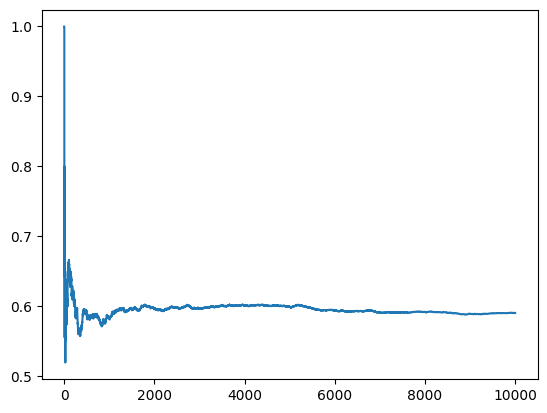

In [23]:
"""#Initialisation
linucb_policy_object = linucb_policy(K_arms = 4, d = 10, alpha=1)

unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object=ctr_simulator(df_test2,linucb_policy_object)
unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object=ctr_simulator(df_test2,linucb_policy_object)
unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object=ctr_simulator(df_test2,linucb_policy_object)
unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object=ctr_simulator(df_test2,linucb_policy_object)
unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object=ctr_simulator(df_test2,linucb_policy_object)
unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object=ctr_simulator(df_test2,linucb_policy_object)
unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object=ctr_simulator(df_test2,linucb_policy_object)
unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object=ctr_simulator(df_test2,linucb_policy_object)
unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object=ctr_simulator(df_test2,linucb_policy_object)
unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object=ctr_simulator(df_test2,linucb_policy_object)
unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object=ctr_simulator(df_test2,linucb_policy_object)
unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object=ctr_simulator(df_test2,linucb_policy_object)
unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object=ctr_simulator(df_test2,linucb_policy_object)
unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object=ctr_simulator(df_test2,linucb_policy_object)
unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object=ctr_simulator(df_test2,linucb_policy_object)
unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object=ctr_simulator(df_test2,linucb_policy_object)
unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object=ctr_simulator(df_test2,linucb_policy_object)
unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object=ctr_simulator(df_test2,linucb_policy_object)
unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object=ctr_simulator(df_test2,linucb_policy_object)
unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object=ctr_simulator(df_test2,linucb_policy_object)
unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object=ctr_simulator(df_test2,linucb_policy_object)
unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object=ctr_simulator(df_test2,linucb_policy_object)
print(aligned_time_steps)
print(cumulative_rewards)
plt.plot(aligned_ctr)
print(aligned_ctr[-1])
plt.show()"""


unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object=ctr_simulator_shift(df_test2,linucb_policy_object)
unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object=ctr_simulator_shift(df_test2,linucb_policy_object)
unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object=ctr_simulator_shift(df_test2,linucb_policy_object)
unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object=ctr_simulator_shift(df_test2,linucb_policy_object)
unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object=ctr_simulator_shift(df_test2,linucb_policy_object)
unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object=ctr_simulator_shift(df_test2,linucb_policy_object)
unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object=ctr_simulator_shift(df_test2,linucb_policy_object)
unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object=ctr_simulator_shift(df_test2,linucb_policy_object)
unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object=ctr_simulator_shift(df_test2,linucb_policy_object)
unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object=ctr_simulator_shift(df_test2,linucb_policy_object)
unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object=ctr_simulator_shift(df_test2,linucb_policy_object)
unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object=ctr_simulator_shift(df_test2,linucb_policy_object)
unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object=ctr_simulator_shift(df_test2,linucb_policy_object)
unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object=ctr_simulator_shift(df_test2,linucb_policy_object)
unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object=ctr_simulator_shift(df_test2,linucb_policy_object)
unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object=ctr_simulator_shift(df_test2,linucb_policy_object)
unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object=ctr_simulator_shift(df_test2,linucb_policy_object)
unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object=ctr_simulator_shift(df_test2,linucb_policy_object)
unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object=ctr_simulator_shift(df_test2,linucb_policy_object)
unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object=ctr_simulator_shift(df_test2,linucb_policy_object)





print(aligned_time_steps)
print(cumulative_rewards)
plt.plot(aligned_ctr)
print(aligned_ctr[-1])
plt.show()

In [24]:
def initiate_ucb_ev_dict():
    result = {}
    for i in range(10):
        result[i]={'p':[],'theta':[],'Incert':[]}
    return result


def evolution_paramètre_arm(arm_id):
    arm_ucb_ev=linucb_policy_object.linucb_arms[arm_id].ucb_evo
    result=initiate_ucb_ev_dict()
    for e in arm_ucb_ev:
        feature = e[0]
        result[feature]['p'].append(e[1])
        result[feature]['theta'].append(e[2])
        result[feature]['Incert'].append(e[3])
    return result



In [25]:
"""r0=evolution_paramètre_arm(0)
r1=evolution_paramètre_arm(1)
plt.plot(r0[9]['p'],label="arm 0 evolution feature 9 son p ")
plt.plot(r1[9]['p'],label="arm 1 evolution feature 9 son p ")
plt.legend()
plt.show()"""


'r0=evolution_paramètre_arm(0)\nr1=evolution_paramètre_arm(1)\nplt.plot(r0[9][\'p\'],label="arm 0 evolution feature 9 son p ")\nplt.plot(r1[9][\'p\'],label="arm 1 evolution feature 9 son p ")\nplt.legend()\nplt.show()'

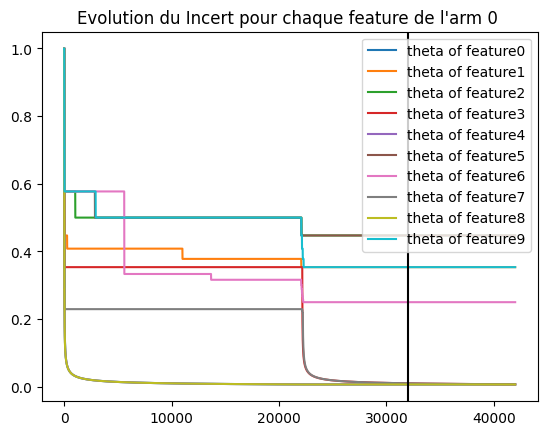

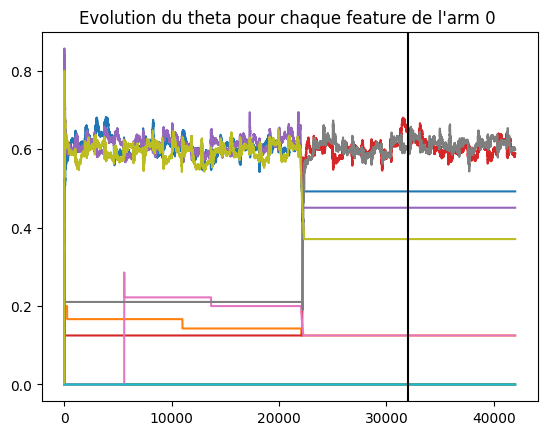

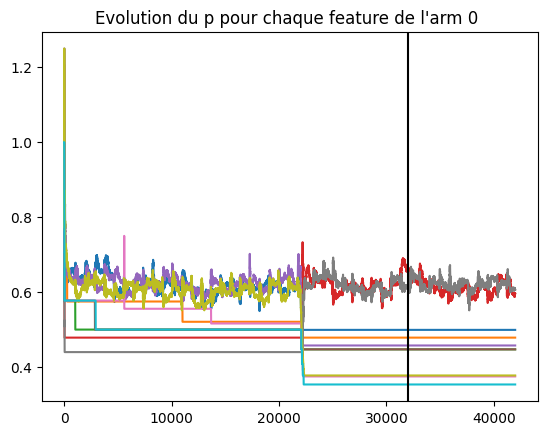

In [26]:
arm = 0
axe=32000
result=evolution_paramètre_arm(arm)
for i in range(10):
    plt.plot(result[i]['Incert'][:], label='theta of feature'+str(i))
plt.axvline(x=axe, color='black')
plt.title("Evolution du Incert pour chaque feature de l'arm 0 ")
plt.legend()
plt.show()
for i in range(10):
    plt.plot(result[i]['theta'][:], label='theta of feature'+str(i))
plt.axvline(x=axe, color='black')
plt.title("Evolution du theta pour chaque feature de l'arm 0 ")
#plt.legend()
plt.show()

for i in range(10):
    plt.plot(result[i]['p'][:], label='theta of feature'+str(i))
plt.axvline(x=axe, color='black')
plt.title("Evolution du p pour chaque feature de l'arm 0 ")
#plt.legend()
plt.show()

# form de la courbe => racine(1/x)=1/racine(x)
# le alpha doit faire en sorte que incercitude doit etre dans le meme ordre de grandeur que theta

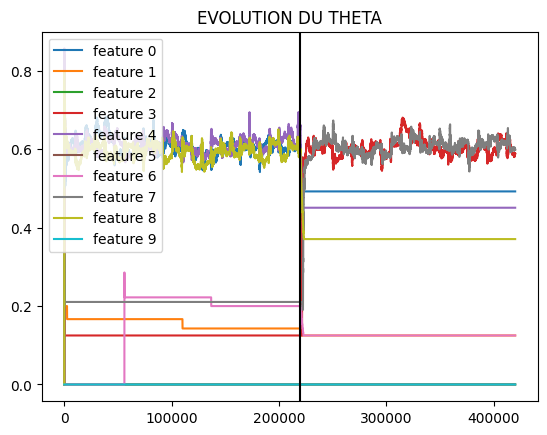

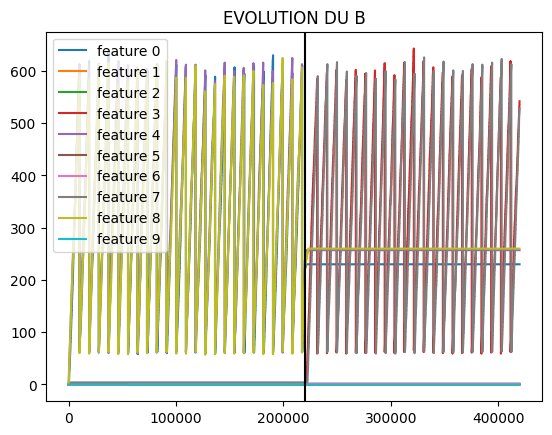

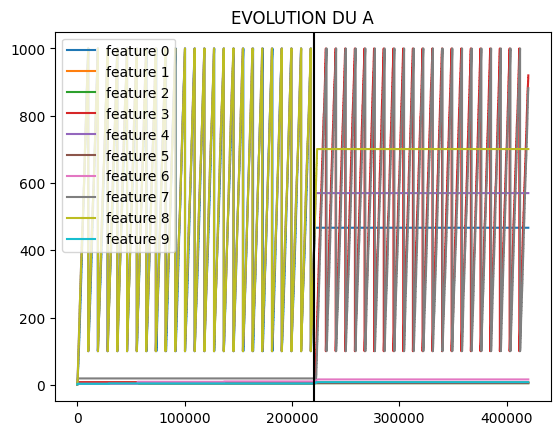

In [28]:
# Créer l'array de données
arm = 0
fromm = 0
to = -1
axe=220000
j=3
u=7
dataT = np.array(linucb_policy_object.linucb_arms[arm].theta_list[fromm:to])
dataB = np.array(linucb_policy_object.linucb_arms[arm].b_list[fromm:to])
dataA = np.array(linucb_policy_object.linucb_arms[arm].A_theta_list[fromm:to])

# Afficher l'évolution de chaque point sur une courbe
for i in range(dataT.shape[1]):
    plt.plot(dataT[:,i,:], label='feature {}'.format(i))

plt.legend()
plt.axvline(x=axe, color='black')
plt.title("EVOLUTION DU THETA")
plt.show()

# Afficher l'évolution de chaque point sur une courbe
for i in range(dataB.shape[1]):
    plt.plot(dataB[:,i,:], label='feature {}'.format(i))
#----
plt.legend()
plt.axvline(x=axe, color='black')
plt.title("EVOLUTION DU B")
plt.show()

# Afficher l'évolution de chaque point sur une courbe
for i in range(dataA.shape[1]):
    plt.plot(dataA[:,i,i], label='feature {}'.format(i))
#----
plt.legend()
plt.axvline(x=axe, color='black')
plt.title("EVOLUTION DU A")
plt.show()




In [2517]:
#0 4 8 -> 3 7